**1. 훈련 가이드라인**

바꿔보면 좋을 것들 (하이퍼파라미터)
1. learning_rate (기본은 0.001; 5배~ 10배씩 바꿔보는 거 추천)
2. scheduler 매개변수 gamma (기본: 에폭마다 0.9 배로 감소; 이건 감으로..)
3. batch size (기본: bs = 32; 한 번의 forward pass / backpropagation 마다 32 장의 이미지를 동시에 고려하는 것; 주의: bs 가 너무 작으면 학습이 안됨)
4. my_transforms 파라미터 (기본: Rescale(256)이고 700x700 을 256x256 으로 바꿔준다는 의미); transforms.Normalize( , ) 시도 해볼만 함
5. optimizer betas (기본: 0.5, 0.99)
6. model_name (기본: 'resnet34'; resnet18, resnet50, resnet101, resnet152 도 시도해볼만 함; 여기서 숫자 34,18, ... 은 layer depth를 의미)

TIP
- validation loss 를 봐야함.. training loss 가 줄어든다는 건 단순히 fitting 잘 된다는 것임
- MSE loss 기반이므로 loss 값 = (실제 좌표로부터의 픽셀 거리)^2 와 비슷함
- classification loss 가 줄어들 수록 분류 경계선을 잘 만들게 filter 가중치가 학습 되는 것이므로 regression 에도 어느 정도 좋은 영향을 주게 됨
- validation loss 의 변동(분산 또는 표준편차)이 크지 않아야 하고 test 이미지의 predicted 좌표의 변화 또한 크지 않을 수록 좋음 
- 데이터의 질과 양이 매우 중요하다.


** 중요: kw, additional_info 에서 지정한 이름으로 텐서보드 로그 / 모델checkpoint 가 생성됨


**2. 텐서보드 사용법**

1. 텐서보드 설치하기

2. cmd 열어서 다음을 입력: 

  cd 'runs' 폴더가 저장된 디렉토리 (runs 폴더를 다운로드 받은 위치)

  tensorboard --logdir=runs --samples_per_plugin=images=50

  예시)

  cd C:\Users\NormalKim\[0_BigData_Acu]\Acupuncture-Points\CV_DeepLearning

  tensorboard --logdir=runs --samples_per_plugin=images=50

  다음과 같은 창이 뜨면 성공임. 표시된 주소인 http://localhost:6006/ 으로 접속하여 결과를 확인하자. (주소는 바꿀 수 있음)


  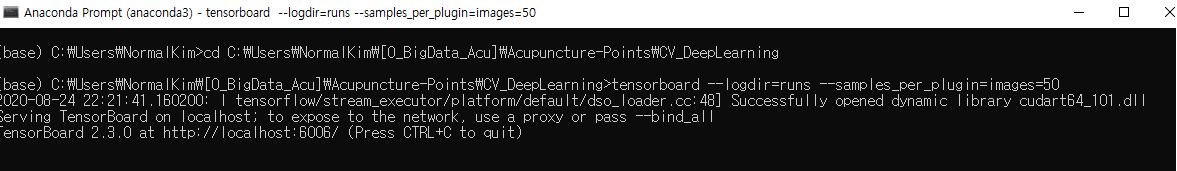



#### Library

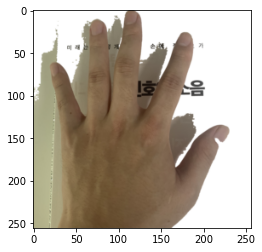

In [1]:
import Training_utils, torchvision
from torchvision import transforms
import tb_utils
from tb_utils import *
from Training_utils import *
from Image_Process_utils import *
import model_utils
from model_utils import *
from Dataset_utils import *
import arg_parser
from arg_parser import common_arg_parser
from torch.utils.data import ConcatDataset

my_transforms = transforms.Compose([
    #transforms.Normalize((0.5,), (0.5,)),
    Rescale(256),
    Tensorize()
    ])

# for creating test image list
test_imlist, target_imlist =  gen_test_img_list()
np_img = np.transpose( to_numpy(test_imlist[0]), (1,2,0))
plt.imshow(np_img)

#### 모델체크포인트 디렉토리

In [2]:
if not os.path.exists('./checkpoints'):
    os.mkdir('./checkpoints')

#### 혈위

In [3]:
kw = 'hapgok'
additional_info = 'all+sc'

#### Initialize

In [4]:
global t_step
global v_step
global test_step
global micro_step
global v_micro
t_step = v_step = test_step = micro_step = v_micro = 0
arg_parser =common_arg_parser()
args, unknown_args = arg_parser.parse_known_args()

#### Dataset Concatenation
- 반드시 IMG_Augemnt.ipynb의 cell을 실행하여 Augmentation 을 먼저 수행해야 함

In [6]:
# data filled
d1= create_dataset(kw, augtype = 'filled', transform = my_transforms)
# data rotated
d2= create_dataset(kw, augtype = 'rotated', transform = my_transforms)
# data rotated-filled
d3= create_dataset(kw, augtype = 'rotated_filled', transform = my_transforms)
# data original
d4= create_dataset(kw, augtype = 'org', transform = my_transforms)
# data scale+translate
d5= create_dataset(kw, augtype = 'sctr', transform = my_transforms)
# data scale+translate + filled
d6= create_dataset(kw, augtype = 'sctr_filled', transform = my_transforms)
concat_dataset = ConcatDataset([d1, d2, d3, d4, d5, d6])

set()
set()
set()
set()
set()


In [7]:
bs = 32 # 바꿔보자 

#### Train,Valid,Test Split

In [8]:
test_set_size = int(len(concat_dataset) * 0.01) # 
train_set_size = len(concat_dataset) - test_set_size
train_set, test_set = torch.utils.data.random_split(concat_dataset, [train_set_size, test_set_size])
valid_set_size = int((train_set_size)*0.1) 
train_set_size = train_set_size - valid_set_size
train_set, valid_set  = torch.utils.data.random_split(train_set, [train_set_size, valid_set_size])
train_set_size, valid_set_size, test_set_size
train_loader = DataLoader(train_set, batch_size = bs, shuffle = True, num_workers=4)
valid_loader = DataLoader(valid_set, batch_size = bs, shuffle = True, num_workers=4)
test_loader = DataLoader(test_set, batch_size = bs, shuffle = True, num_workers=4)

train_set_size, valid_set_size, test_set_size

(24401, 2711, 273)

#### 모델 / 로스 초기화 및 하이퍼파리미터 설정

In [9]:
model_name = 'resnet34' # 
model = create_model(model_name)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device: ', device) # cuda:0 뜨면 gpu 
model.to(device) # model gpu 로 바꿔주자 

best_val = 100000000
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = (0.5, 0.999))
scheduler = StepLR(optimizer, step_size = 1, gamma = 0.9)
class_loss = class_loss()
coord_loss = coord_loss()
today = str(datetime.datetime.now().today())
time_info = today[5:7] +today[8:10] + '_' + today[11:13] + today[14:16]
args.prefix = kw + time_info + additional_info
args.epochs = 80
writer = SummaryWriter('runs/'+args.prefix)

device:  cuda:0


#### 훈련 루프

In [10]:
for epoch in range(args.start_epoch, args.epochs):
    tr_loss, micro_step, t_step =  train(model, train_loader, optimizer, coord_loss, class_loss, epoch, writer, micro_step, t_step)
    val_loss, v_micro, v_step = validate(model, valid_loader, coord_loss, class_loss, epoch, writer, v_micro, v_step)
    test_step = test(test_imlist, target_imlist, model, writer, 'test_image', test_step)
    writer.flush()
    
    val_loss
    is_best = sum(val_loss[0:2]) < best_val
    best_val = min( sum(val_loss[0:2]), best_val )
    
    save_checkpoint({
        'epoch' : epoch,
        'model' : args.model, 
        'state_dict' : model.state_dict(),
        'best_val' : best_val, 
        'optimizer' : optimizer.state_dict(),
        'scheduler' : scheduler.state_dict()
    }, is_best, args.prefix)
    
    scheduler.step()

Epoch[1] Batch 10/763  Time 0.914s Data 0.614s || LOSS: CLS 0.712 X 15454.62 Y 29320.44 tot 44775.769 | Current: 18:06:09
Epoch[1] Batch 20/763  Time 0.557s Data 0.323s || LOSS: CLS 0.713 X 14170.45 Y 27953.27 tot 42124.431 | Current: 18:06:11
Epoch[1] Batch 30/763  Time 0.429s Data 0.221s || LOSS: CLS 0.713 X 13578.53 Y 25928.39 tot 39507.631 | Current: 18:06:12
Epoch[1] Batch 40/763  Time 0.364s Data 0.168s || LOSS: CLS 0.717 X 12611.15 Y 24365.39 tot 36977.258 | Current: 18:06:14
Epoch[1] Batch 50/763  Time 0.324s Data 0.136s || LOSS: CLS 0.714 X 11565.98 Y 23213.85 tot 34780.544 | Current: 18:06:15
Epoch[1] Batch 60/763  Time 0.298s Data 0.114s || LOSS: CLS 0.716 X 10567.02 Y 21965.04 tot 32532.776 | Current: 18:06:17
Epoch[1] Batch 70/763  Time 0.279s Data 0.099s || LOSS: CLS 0.722 X 9710.72 Y 20585.60 tot 30297.044 | Current: 18:06:19
Epoch[1] Batch 80/763  Time 0.264s Data 0.087s || LOSS: CLS 0.722 X 8973.91 Y 19274.45 tot 28249.082 | Current: 18:06:20
Epoch[1] Batch 90/763  Tim

Epoch[1] Batch 690/763  Time 0.174s Data 0.014s || LOSS: CLS 0.707 X 1865.24 Y 3362.72 tot 5228.672 | Current: 18:07:59
Epoch[1] Batch 700/763  Time 0.174s Data 0.013s || LOSS: CLS 0.706 X 1843.48 Y 3320.36 tot 5164.545 | Current: 18:08:01
Epoch[1] Batch 710/763  Time 0.174s Data 0.013s || LOSS: CLS 0.706 X 1823.78 Y 3279.78 tot 5104.259 | Current: 18:08:02
Epoch[1] Batch 720/763  Time 0.174s Data 0.013s || LOSS: CLS 0.706 X 1805.75 Y 3240.46 tot 5046.925 | Current: 18:08:04
Epoch[1] Batch 730/763  Time 0.173s Data 0.013s || LOSS: CLS 0.706 X 1785.70 Y 3202.69 tot 4989.095 | Current: 18:08:06
Epoch[1] Batch 740/763  Time 0.173s Data 0.013s || LOSS: CLS 0.706 X 1769.37 Y 3166.24 tot 4936.315 | Current: 18:08:07
Epoch[1] Batch 750/763  Time 0.173s Data 0.013s || LOSS: CLS 0.705 X 1751.52 Y 3129.61 tot 4881.832 | Current: 18:08:09
Epoch[1] Batch 760/763  Time 0.173s Data 0.013s || LOSS: CLS 0.704 X 1733.43 Y 3094.99 tot 4829.124 | Current: 18:08:10
Epoch[1] Batch 10/85  Time 0.949s || LOS

Epoch[2] Batch 560/763  Time 0.176s Data 0.017s || LOSS: CLS 0.640 X 333.79 Y 331.09 tot 665.525 | Current: 18:10:27
Epoch[2] Batch 570/763  Time 0.176s Data 0.016s || LOSS: CLS 0.639 X 331.11 Y 328.41 tot 660.159 | Current: 18:10:29
Epoch[2] Batch 580/763  Time 0.175s Data 0.016s || LOSS: CLS 0.638 X 329.02 Y 327.01 tot 656.670 | Current: 18:10:30
Epoch[2] Batch 590/763  Time 0.175s Data 0.016s || LOSS: CLS 0.638 X 328.17 Y 326.98 tot 655.794 | Current: 18:10:32
Epoch[2] Batch 600/763  Time 0.175s Data 0.016s || LOSS: CLS 0.637 X 327.31 Y 325.18 tot 653.134 | Current: 18:10:34
Epoch[2] Batch 610/763  Time 0.175s Data 0.015s || LOSS: CLS 0.637 X 326.17 Y 322.90 tot 649.709 | Current: 18:10:35
Epoch[2] Batch 620/763  Time 0.174s Data 0.015s || LOSS: CLS 0.636 X 324.00 Y 320.13 tot 644.773 | Current: 18:10:37
Epoch[2] Batch 630/763  Time 0.174s Data 0.015s || LOSS: CLS 0.636 X 321.72 Y 317.90 tot 640.252 | Current: 18:10:38
Epoch[2] Batch 640/763  Time 0.174s Data 0.015s || LOSS: CLS 0.6

Epoch[3] Batch 430/763  Time 0.172s Data 0.019s || LOSS: CLS 0.568 X 179.80 Y 187.88 tot 368.247 | Current: 18:12:49
Epoch[3] Batch 440/763  Time 0.172s Data 0.019s || LOSS: CLS 0.567 X 179.02 Y 185.86 tot 365.442 | Current: 18:12:51
Epoch[3] Batch 450/763  Time 0.172s Data 0.019s || LOSS: CLS 0.567 X 177.84 Y 184.75 tot 363.157 | Current: 18:12:52
Epoch[3] Batch 460/763  Time 0.171s Data 0.018s || LOSS: CLS 0.567 X 176.36 Y 183.42 tot 360.348 | Current: 18:12:54
Epoch[3] Batch 470/763  Time 0.171s Data 0.018s || LOSS: CLS 0.566 X 174.72 Y 181.90 tot 357.180 | Current: 18:12:55
Epoch[3] Batch 480/763  Time 0.171s Data 0.018s || LOSS: CLS 0.565 X 177.74 Y 183.45 tot 361.757 | Current: 18:12:57
Epoch[3] Batch 490/763  Time 0.171s Data 0.018s || LOSS: CLS 0.565 X 177.88 Y 183.64 tot 362.086 | Current: 18:12:59
Epoch[3] Batch 500/763  Time 0.170s Data 0.017s || LOSS: CLS 0.565 X 177.46 Y 182.83 tot 360.856 | Current: 18:13:00
Epoch[3] Batch 510/763  Time 0.170s Data 0.017s || LOSS: CLS 0.5

Epoch[4] Batch 310/763  Time 0.184s Data 0.027s || LOSS: CLS 0.501 X 101.63 Y 96.86 tot 198.989 | Current: 18:15:15
Epoch[4] Batch 320/763  Time 0.184s Data 0.026s || LOSS: CLS 0.500 X 101.31 Y 96.24 tot 198.046 | Current: 18:15:17
Epoch[4] Batch 330/763  Time 0.184s Data 0.025s || LOSS: CLS 0.501 X 100.18 Y 96.61 tot 197.294 | Current: 18:15:19
Epoch[4] Batch 340/763  Time 0.183s Data 0.025s || LOSS: CLS 0.500 X 100.02 Y 95.90 tot 196.415 | Current: 18:15:20
Epoch[4] Batch 350/763  Time 0.183s Data 0.024s || LOSS: CLS 0.500 X 99.75 Y 94.92 tot 195.170 | Current: 18:15:22
Epoch[4] Batch 360/763  Time 0.183s Data 0.024s || LOSS: CLS 0.500 X 99.89 Y 94.59 tot 194.974 | Current: 18:15:24
Epoch[4] Batch 370/763  Time 0.183s Data 0.023s || LOSS: CLS 0.500 X 100.87 Y 95.12 tot 196.496 | Current: 18:15:26
Epoch[4] Batch 380/763  Time 0.182s Data 0.023s || LOSS: CLS 0.499 X 100.04 Y 94.70 tot 195.242 | Current: 18:15:27
Epoch[4] Batch 390/763  Time 0.182s Data 0.022s || LOSS: CLS 0.499 X 100.1

Epoch[5] Batch 190/763  Time 0.221s Data 0.045s || LOSS: CLS 0.436 X 76.02 Y 64.19 tot 140.646 | Current: 18:17:58
Epoch[5] Batch 200/763  Time 0.219s Data 0.043s || LOSS: CLS 0.436 X 76.24 Y 64.51 tot 141.181 | Current: 18:18:00
Epoch[5] Batch 210/763  Time 0.217s Data 0.041s || LOSS: CLS 0.437 X 75.97 Y 64.41 tot 140.824 | Current: 18:18:02
Epoch[5] Batch 220/763  Time 0.215s Data 0.040s || LOSS: CLS 0.438 X 75.12 Y 63.58 tot 139.144 | Current: 18:18:03
Epoch[5] Batch 230/763  Time 0.214s Data 0.038s || LOSS: CLS 0.438 X 74.35 Y 63.67 tot 138.462 | Current: 18:18:05
Epoch[5] Batch 240/763  Time 0.212s Data 0.037s || LOSS: CLS 0.438 X 74.20 Y 65.13 tot 139.760 | Current: 18:18:07
Epoch[5] Batch 250/763  Time 0.211s Data 0.036s || LOSS: CLS 0.436 X 73.65 Y 65.14 tot 139.230 | Current: 18:18:09
Epoch[5] Batch 260/763  Time 0.210s Data 0.034s || LOSS: CLS 0.436 X 73.24 Y 65.26 tot 138.939 | Current: 18:18:11
Epoch[5] Batch 270/763  Time 0.208s Data 0.033s || LOSS: CLS 0.435 X 72.23 Y 64.

Epoch[6] Batch 70/763  Time 0.255s Data 0.103s || LOSS: CLS 0.402 X 67.22 Y 69.16 tot 136.782 | Current: 18:20:33
Epoch[6] Batch 80/763  Time 0.244s Data 0.091s || LOSS: CLS 0.399 X 65.58 Y 70.51 tot 136.496 | Current: 18:20:35
Epoch[6] Batch 90/763  Time 0.234s Data 0.082s || LOSS: CLS 0.395 X 65.55 Y 71.92 tot 137.866 | Current: 18:20:36
Epoch[6] Batch 100/763  Time 0.227s Data 0.074s || LOSS: CLS 0.397 X 64.76 Y 71.29 tot 136.449 | Current: 18:20:38
Epoch[6] Batch 110/763  Time 0.220s Data 0.068s || LOSS: CLS 0.399 X 65.54 Y 70.10 tot 136.038 | Current: 18:20:40
Epoch[6] Batch 120/763  Time 0.215s Data 0.062s || LOSS: CLS 0.400 X 63.54 Y 69.58 tot 133.524 | Current: 18:20:41
Epoch[6] Batch 130/763  Time 0.212s Data 0.058s || LOSS: CLS 0.401 X 64.34 Y 68.40 tot 133.140 | Current: 18:20:43
Epoch[6] Batch 140/763  Time 0.208s Data 0.054s || LOSS: CLS 0.400 X 63.63 Y 68.43 tot 132.458 | Current: 18:20:44
Epoch[6] Batch 150/763  Time 0.205s Data 0.051s || LOSS: CLS 0.400 X 63.71 Y 67.94 

Epoch[6] Batch 30/85  Time 0.600s || LOSS: CLS 0.381 X 57.93 Y 58.94 tot 117.249 | Current: 18:22:53
Epoch[6] Batch 40/85  Time 0.517s || LOSS: CLS 0.386 X 57.35 Y 57.36 tot 115.094 | Current: 18:22:56
Epoch[6] Batch 50/85  Time 0.497s || LOSS: CLS 0.381 X 55.37 Y 56.60 tot 112.352 | Current: 18:23:00
Epoch[6] Batch 60/85  Time 0.470s || LOSS: CLS 0.378 X 56.00 Y 55.95 tot 112.320 | Current: 18:23:03
Epoch[6] Batch 70/85  Time 0.468s || LOSS: CLS 0.374 X 55.04 Y 54.18 tot 109.590 | Current: 18:23:08
Epoch[6] Batch 80/85  Time 0.449s || LOSS: CLS 0.376 X 55.72 Y 53.77 tot 109.870 | Current: 18:23:11
writing test img with step 5
Epoch[7] Batch 10/763  Time 1.126s Data 0.969s || LOSS: CLS 0.414 X 46.42 Y 44.29 tot 91.131 | Current: 18:23:30
Epoch[7] Batch 20/763  Time 0.666s Data 0.510s || LOSS: CLS 0.382 X 42.52 Y 60.48 tot 103.381 | Current: 18:23:31
Epoch[7] Batch 30/763  Time 0.502s Data 0.347s || LOSS: CLS 0.378 X 42.31 Y 61.89 tot 104.572 | Current: 18:23:33
Epoch[7] Batch 40/763  T

Epoch[7] Batch 680/763  Time 0.179s Data 0.023s || LOSS: CLS 0.363 X 42.63 Y 48.32 tot 91.321 | Current: 18:25:19
Epoch[7] Batch 690/763  Time 0.178s Data 0.022s || LOSS: CLS 0.363 X 42.72 Y 48.32 tot 91.403 | Current: 18:25:20
Epoch[7] Batch 700/763  Time 0.178s Data 0.022s || LOSS: CLS 0.363 X 42.56 Y 48.29 tot 91.222 | Current: 18:25:22
Epoch[7] Batch 710/763  Time 0.177s Data 0.022s || LOSS: CLS 0.362 X 42.57 Y 48.13 tot 91.067 | Current: 18:25:23
Epoch[7] Batch 720/763  Time 0.177s Data 0.022s || LOSS: CLS 0.361 X 42.32 Y 47.96 tot 90.638 | Current: 18:25:25
Epoch[7] Batch 730/763  Time 0.177s Data 0.021s || LOSS: CLS 0.361 X 42.17 Y 47.85 tot 90.377 | Current: 18:25:26
Epoch[7] Batch 740/763  Time 0.176s Data 0.021s || LOSS: CLS 0.361 X 42.01 Y 47.68 tot 90.050 | Current: 18:25:28
Epoch[7] Batch 750/763  Time 0.176s Data 0.021s || LOSS: CLS 0.361 X 41.88 Y 47.85 tot 90.099 | Current: 18:25:29
Epoch[7] Batch 760/763  Time 0.176s Data 0.021s || LOSS: CLS 0.361 X 41.72 Y 47.70 tot 8

Epoch[8] Batch 570/763  Time 0.172s Data 0.017s || LOSS: CLS 0.330 X 28.02 Y 34.53 tot 62.879 | Current: 18:27:47
Epoch[8] Batch 580/763  Time 0.172s Data 0.017s || LOSS: CLS 0.330 X 27.95 Y 34.49 tot 62.768 | Current: 18:27:49
Epoch[8] Batch 590/763  Time 0.172s Data 0.016s || LOSS: CLS 0.330 X 27.84 Y 34.53 tot 62.706 | Current: 18:27:50
Epoch[8] Batch 600/763  Time 0.172s Data 0.016s || LOSS: CLS 0.329 X 27.79 Y 34.57 tot 62.695 | Current: 18:27:52
Epoch[8] Batch 610/763  Time 0.172s Data 0.016s || LOSS: CLS 0.329 X 27.77 Y 34.69 tot 62.793 | Current: 18:27:54
Epoch[8] Batch 620/763  Time 0.172s Data 0.016s || LOSS: CLS 0.330 X 27.80 Y 34.64 tot 62.770 | Current: 18:27:55
Epoch[8] Batch 630/763  Time 0.172s Data 0.016s || LOSS: CLS 0.329 X 27.77 Y 34.60 tot 62.703 | Current: 18:27:57
Epoch[8] Batch 640/763  Time 0.172s Data 0.016s || LOSS: CLS 0.329 X 27.73 Y 34.58 tot 62.643 | Current: 18:27:59
Epoch[8] Batch 650/763  Time 0.172s Data 0.015s || LOSS: CLS 0.328 X 27.71 Y 34.59 tot 6

Epoch[9] Batch 460/763  Time 0.178s Data 0.021s || LOSS: CLS 0.301 X 21.80 Y 27.81 tot 49.916 | Current: 18:30:19
Epoch[9] Batch 470/763  Time 0.178s Data 0.021s || LOSS: CLS 0.300 X 21.69 Y 28.08 tot 50.071 | Current: 18:30:21
Epoch[9] Batch 480/763  Time 0.178s Data 0.021s || LOSS: CLS 0.300 X 21.67 Y 28.16 tot 50.136 | Current: 18:30:23
Epoch[9] Batch 490/763  Time 0.177s Data 0.020s || LOSS: CLS 0.300 X 21.59 Y 28.17 tot 50.058 | Current: 18:30:24
Epoch[9] Batch 500/763  Time 0.177s Data 0.020s || LOSS: CLS 0.299 X 21.52 Y 28.22 tot 50.043 | Current: 18:30:26
Epoch[9] Batch 510/763  Time 0.177s Data 0.020s || LOSS: CLS 0.299 X 21.57 Y 28.22 tot 50.093 | Current: 18:30:28
Epoch[9] Batch 520/763  Time 0.177s Data 0.019s || LOSS: CLS 0.299 X 21.53 Y 28.19 tot 50.020 | Current: 18:30:29
Epoch[9] Batch 530/763  Time 0.177s Data 0.019s || LOSS: CLS 0.299 X 21.62 Y 28.23 tot 50.144 | Current: 18:30:31
Epoch[9] Batch 540/763  Time 0.177s Data 0.019s || LOSS: CLS 0.299 X 21.76 Y 28.30 tot 5

Epoch[10] Batch 350/763  Time 0.187s Data 0.025s || LOSS: CLS 0.274 X 19.02 Y 24.34 tot 43.632 | Current: 18:32:53
Epoch[10] Batch 360/763  Time 0.187s Data 0.024s || LOSS: CLS 0.275 X 19.06 Y 24.39 tot 43.718 | Current: 18:32:55
Epoch[10] Batch 370/763  Time 0.186s Data 0.024s || LOSS: CLS 0.274 X 19.06 Y 24.43 tot 43.766 | Current: 18:32:57
Epoch[10] Batch 380/763  Time 0.185s Data 0.023s || LOSS: CLS 0.274 X 18.92 Y 24.37 tot 43.565 | Current: 18:32:58
Epoch[10] Batch 390/763  Time 0.185s Data 0.023s || LOSS: CLS 0.273 X 18.83 Y 24.59 tot 43.696 | Current: 18:33:00
Epoch[10] Batch 400/763  Time 0.185s Data 0.023s || LOSS: CLS 0.272 X 18.81 Y 24.66 tot 43.749 | Current: 18:33:02
Epoch[10] Batch 410/763  Time 0.184s Data 0.022s || LOSS: CLS 0.272 X 18.74 Y 24.61 tot 43.632 | Current: 18:33:03
Epoch[10] Batch 420/763  Time 0.184s Data 0.022s || LOSS: CLS 0.272 X 18.70 Y 24.55 tot 43.520 | Current: 18:33:05
Epoch[10] Batch 430/763  Time 0.183s Data 0.021s || LOSS: CLS 0.272 X 18.83 Y 24

Epoch[11] Batch 240/763  Time 0.197s Data 0.035s || LOSS: CLS 0.245 X 17.29 Y 21.18 tot 38.714 | Current: 18:35:27
Epoch[11] Batch 250/763  Time 0.196s Data 0.033s || LOSS: CLS 0.246 X 17.30 Y 21.15 tot 38.692 | Current: 18:35:29
Epoch[11] Batch 260/763  Time 0.194s Data 0.032s || LOSS: CLS 0.245 X 17.40 Y 21.12 tot 38.762 | Current: 18:35:31
Epoch[11] Batch 270/763  Time 0.193s Data 0.031s || LOSS: CLS 0.244 X 17.32 Y 21.13 tot 38.693 | Current: 18:35:32
Epoch[11] Batch 280/763  Time 0.193s Data 0.030s || LOSS: CLS 0.245 X 17.18 Y 21.29 tot 38.716 | Current: 18:35:34
Epoch[11] Batch 290/763  Time 0.192s Data 0.030s || LOSS: CLS 0.245 X 17.41 Y 21.33 tot 38.990 | Current: 18:35:36
Epoch[11] Batch 300/763  Time 0.191s Data 0.029s || LOSS: CLS 0.246 X 17.37 Y 21.73 tot 39.352 | Current: 18:35:37
Epoch[11] Batch 310/763  Time 0.190s Data 0.028s || LOSS: CLS 0.246 X 17.48 Y 21.75 tot 39.482 | Current: 18:35:39
Epoch[11] Batch 320/763  Time 0.189s Data 0.027s || LOSS: CLS 0.246 X 17.48 Y 21

Epoch[12] Batch 120/763  Time 0.226s Data 0.064s || LOSS: CLS 0.265 X 33.40 Y 45.41 tot 79.075 | Current: 18:38:01
Epoch[12] Batch 130/763  Time 0.222s Data 0.060s || LOSS: CLS 0.263 X 32.60 Y 44.28 tot 77.138 | Current: 18:38:03
Epoch[12] Batch 140/763  Time 0.218s Data 0.056s || LOSS: CLS 0.262 X 31.85 Y 43.76 tot 75.878 | Current: 18:38:04
Epoch[12] Batch 150/763  Time 0.215s Data 0.052s || LOSS: CLS 0.262 X 30.99 Y 42.71 tot 73.969 | Current: 18:38:06
Epoch[12] Batch 160/763  Time 0.212s Data 0.049s || LOSS: CLS 0.259 X 30.73 Y 42.02 tot 73.012 | Current: 18:38:08
Epoch[12] Batch 170/763  Time 0.210s Data 0.047s || LOSS: CLS 0.256 X 30.13 Y 41.29 tot 71.672 | Current: 18:38:09
Epoch[12] Batch 180/763  Time 0.208s Data 0.044s || LOSS: CLS 0.255 X 29.72 Y 40.78 tot 70.750 | Current: 18:38:11
Epoch[12] Batch 190/763  Time 0.206s Data 0.042s || LOSS: CLS 0.255 X 29.37 Y 39.98 tot 69.598 | Current: 18:38:13
Epoch[12] Batch 200/763  Time 0.204s Data 0.041s || LOSS: CLS 0.254 X 28.78 Y 39

writing test img with step 11
Epoch[13] Batch 10/763  Time 0.838s Data 0.676s || LOSS: CLS 0.184 X 11.53 Y 16.01 tot 27.724 | Current: 18:40:41
Epoch[13] Batch 20/763  Time 0.514s Data 0.356s || LOSS: CLS 0.199 X 12.07 Y 18.64 tot 30.906 | Current: 18:40:42
Epoch[13] Batch 30/763  Time 0.399s Data 0.243s || LOSS: CLS 0.202 X 12.43 Y 17.72 tot 30.345 | Current: 18:40:44
Epoch[13] Batch 40/763  Time 0.339s Data 0.185s || LOSS: CLS 0.212 X 12.97 Y 18.01 tot 31.190 | Current: 18:40:45
Epoch[13] Batch 50/763  Time 0.305s Data 0.150s || LOSS: CLS 0.209 X 12.83 Y 17.62 tot 30.652 | Current: 18:40:47
Epoch[13] Batch 60/763  Time 0.280s Data 0.126s || LOSS: CLS 0.208 X 12.52 Y 17.48 tot 30.204 | Current: 18:40:49
Epoch[13] Batch 70/763  Time 0.262s Data 0.109s || LOSS: CLS 0.210 X 12.90 Y 17.94 tot 31.054 | Current: 18:40:50
Epoch[13] Batch 80/763  Time 0.248s Data 0.096s || LOSS: CLS 0.213 X 13.30 Y 17.51 tot 31.027 | Current: 18:40:52
Epoch[13] Batch 90/763  Time 0.238s Data 0.086s || LOSS: C

Epoch[13] Batch 730/763  Time 0.172s Data 0.015s || LOSS: CLS 0.208 X 13.87 Y 17.37 tot 31.445 | Current: 18:42:38
Epoch[13] Batch 740/763  Time 0.172s Data 0.015s || LOSS: CLS 0.208 X 13.84 Y 17.37 tot 31.420 | Current: 18:42:39
Epoch[13] Batch 750/763  Time 0.172s Data 0.015s || LOSS: CLS 0.207 X 13.84 Y 17.31 tot 31.355 | Current: 18:42:41
Epoch[13] Batch 760/763  Time 0.172s Data 0.015s || LOSS: CLS 0.207 X 13.80 Y 17.28 tot 31.292 | Current: 18:42:43
Epoch[13] Batch 10/85  Time 1.158s || LOSS: CLS 0.181 X 13.50 Y 17.67 tot 31.348 | Current: 18:42:56
Epoch[13] Batch 20/85  Time 0.753s || LOSS: CLS 0.184 X 16.13 Y 17.50 tot 33.811 | Current: 18:43:00
Epoch[13] Batch 30/85  Time 0.646s || LOSS: CLS 0.183 X 15.81 Y 18.51 tot 34.508 | Current: 18:43:04
Epoch[13] Batch 40/85  Time 0.563s || LOSS: CLS 0.176 X 15.44 Y 18.86 tot 34.476 | Current: 18:43:07
Epoch[13] Batch 50/85  Time 0.537s || LOSS: CLS 0.178 X 15.16 Y 18.66 tot 33.997 | Current: 18:43:11
Epoch[13] Batch 60/85  Time 0.500s 

Epoch[14] Batch 620/763  Time 0.188s Data 0.019s || LOSS: CLS 0.185 X 12.27 Y 15.06 tot 27.519 | Current: 18:45:24
Epoch[14] Batch 630/763  Time 0.188s Data 0.019s || LOSS: CLS 0.184 X 12.28 Y 15.13 tot 27.597 | Current: 18:45:25
Epoch[14] Batch 640/763  Time 0.188s Data 0.019s || LOSS: CLS 0.184 X 12.29 Y 15.17 tot 27.640 | Current: 18:45:27
Epoch[14] Batch 650/763  Time 0.187s Data 0.019s || LOSS: CLS 0.184 X 12.29 Y 15.18 tot 27.654 | Current: 18:45:29
Epoch[14] Batch 660/763  Time 0.187s Data 0.018s || LOSS: CLS 0.185 X 12.25 Y 15.15 tot 27.590 | Current: 18:45:31
Epoch[14] Batch 670/763  Time 0.187s Data 0.018s || LOSS: CLS 0.184 X 12.29 Y 15.16 tot 27.631 | Current: 18:45:32
Epoch[14] Batch 680/763  Time 0.186s Data 0.018s || LOSS: CLS 0.184 X 12.27 Y 15.19 tot 27.640 | Current: 18:45:34
Epoch[14] Batch 690/763  Time 0.186s Data 0.018s || LOSS: CLS 0.184 X 12.27 Y 15.18 tot 27.631 | Current: 18:45:36
Epoch[14] Batch 700/763  Time 0.186s Data 0.018s || LOSS: CLS 0.184 X 12.27 Y 15

Epoch[15] Batch 510/763  Time 0.182s Data 0.019s || LOSS: CLS 0.170 X 11.22 Y 13.83 tot 25.220 | Current: 18:48:01
Epoch[15] Batch 520/763  Time 0.181s Data 0.019s || LOSS: CLS 0.170 X 11.22 Y 13.81 tot 25.200 | Current: 18:48:03
Epoch[15] Batch 530/763  Time 0.181s Data 0.019s || LOSS: CLS 0.170 X 11.18 Y 13.82 tot 25.174 | Current: 18:48:04
Epoch[15] Batch 540/763  Time 0.181s Data 0.019s || LOSS: CLS 0.170 X 11.20 Y 13.87 tot 25.249 | Current: 18:48:06
Epoch[15] Batch 550/763  Time 0.180s Data 0.018s || LOSS: CLS 0.170 X 11.20 Y 13.84 tot 25.207 | Current: 18:48:08
Epoch[15] Batch 560/763  Time 0.180s Data 0.018s || LOSS: CLS 0.169 X 11.18 Y 13.77 tot 25.115 | Current: 18:48:10
Epoch[15] Batch 570/763  Time 0.180s Data 0.018s || LOSS: CLS 0.169 X 11.17 Y 13.78 tot 25.125 | Current: 18:48:11
Epoch[15] Batch 580/763  Time 0.180s Data 0.018s || LOSS: CLS 0.169 X 11.21 Y 13.77 tot 25.151 | Current: 18:48:13
Epoch[15] Batch 590/763  Time 0.180s Data 0.017s || LOSS: CLS 0.169 X 11.22 Y 13

KeyboardInterrupt: 

#### 훈련 결과물 testing

97.06102 184.92444


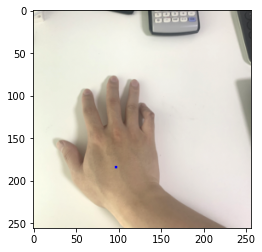

In [14]:
# testdata 폴더에 이미지 넣고 직접 테스트 해보는 것도 가능 
# 이때 모델이 훈련한 사이즈로 resize 해줘야 함 (기본:256)

i = 4
dir1 = './testdata/test' + str(i) + '.jpg'
img = Image.open(dir1)
img = img.rotate(-90)
transform = transforms.Compose([transforms.Resize(size = 256),transforms.ToTensor()])
img = transform(img)
np_img = np.transpose( to_numpy(img), (1,2,0))

img2 = clear_background(cv2.imread(dir1))
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
im_pil = Image.fromarray(img2)
img2 = transform(im_pil)

_, out2 = model(img2.unsqueeze(0).to('cuda'))
x,y = to_numpy(out2)[0]
print(x,y)
plt.imshow(create_circle_patch(np_img, x, y, color = 'blue'))

#### 기존 훈련된 모델 재사용시
- 이 셀 실행 후 위에 for-loop 다시 돌리기

In [ ]:
# checkpoint 폴더에 있는 파일명을 넣으면 해당 지점부터 train 다시 시작함

# 체크포인트 폴더에 저장된 모델 가중치 이름을 불러오기
args.resume = './checkpoints/urjae0830_2323all+sc+sc_filled_model_best.pth.tar'

if args.resume:
    if os.path.isfile(args.resume):
        print("=> loading checkpoint '{}'".format(args.resume))
        checkpoint = torch.load(args.resume)
        args.start_epoch = checkpoint['epoch']
        best_val = checkpoint['best_val']
        model.load_state_dict(checkpoint['state_dict'])
        if 'optimizer' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {})"
              .format(args.resume, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(args.resume))